In [1]:
%matplotlib inline 

import random
import torch 
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import h5py
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
import torch.optim as optim
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy

In [2]:
# clearing cuda cache memory
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [3]:
os.listdir("../dataset")

['QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272',
 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
 'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540',
 'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
 'QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494',
 'QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet',
 'quark-gluon_data-set_n139306.hdf5',
 'SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5',
 'SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5']

In [4]:
# import dataset
QuarkGluon_dataset = h5py.File("../dataset/quark-gluon_data-set_n139306.hdf5","r")
# truncating the dataset into a small one
random.seed(42)
sample_size = 75000
random_trunc = random.sample(range(0, 139306), sample_size)

In [5]:
QuarkGluon_imgs=np.array(QuarkGluon_dataset["X_jets"])[random_trunc]

In [6]:
img_arrs = torch.Tensor(QuarkGluon_imgs)

In [7]:
class QuarkGluonDataset(Dataset):
    def __init__(self,split_inx, transform=None,target_transform= None):
        self.img_arrs_split = img_arrs[split_inx]
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return self.img_arrs_split.shape[0]
    def __getitem__(self,idx):
        image=self.img_arrs_split[idx,:,:,:]
        # changing the dim of image to channels, height, width by transposing the
        # original image tensor.
        image = image.permute(2,1,0)
        if self.transform:
            image = self.transform(image)
        return image, -1

In [8]:
class ResidualUnitEnc(nn.Module):
    def __init__(self,in_channels, out_channels, **kwargs):
        super().__init__(**kwargs)
        strides = 1
        if in_channels == out_channels:
            strides = 1
            pad = "same"
        else:
            strides = 2
            pad = 1
        self.relu = nn.ReLU(inplace=True)
        self.main_layers = nn.ModuleList([
            nn.Conv2d(in_channels,out_channels,3,strides,padding=pad,bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
            nn.Conv2d(out_channels,out_channels,3,stride=1,padding="same",bias=False),
            nn.BatchNorm2d(out_channels)
        ])
        
        self.skip_layers =[]
        if strides > 1 :
            self.skip_layers = nn.ModuleList([
                nn.Conv2d(in_channels,out_channels,1,strides,padding=0,bias=False),
                nn.BatchNorm2d(out_channels)
            ])
    def forward(self,x):
        Z = x 
        for layer in self.main_layers:
            Z = layer(Z)
        skip_z = x
        for layer in self.skip_layers:
            skip_z= layer(skip_z)
        return self.relu(Z + skip_z)  
    
class ResidualUnitDec(nn.Module):
    def __init__(self,in_channels, out_channels, **kwargs):
        super().__init__(**kwargs)
        strides = 1
        if in_channels == out_channels:
            strides = 1
            pad = 1
            out_pad =0 
        else:
            strides = 2
            pad = 1
            out_pad  =1 
            
        self.relu = nn.ReLU(inplace=True)    
        self.main_layers = nn.ModuleList([
            nn.ConvTranspose2d(in_channels,out_channels,3,strides,padding=pad,output_padding=out_pad,bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
            nn.ConvTranspose2d(out_channels,out_channels,3,stride=1,padding=pad,bias=False),
            nn.BatchNorm2d(out_channels)
        ])
        
        self.skip_layers =[]
        if strides > 1 :
            self.skip_layers = nn.ModuleList([
                nn.ConvTranspose2d(in_channels,out_channels,1,strides,padding=0,output_padding=out_pad,bias=False),
                nn.BatchNorm2d(out_channels)
            ])
            
    def forward(self,x):
        Z = x 
        for layer in self.main_layers:
            Z = layer(Z)
        skip_z = x
        for layer in self.skip_layers:
            skip_z= layer(skip_z)
        return self.relu(Z + skip_z)  

In [9]:
class ResNet18Enc(nn.Module):
    def __init__(self,latent_dim):
        super(ResNet18Enc, self).__init__()

        self.latent_dim = latent_dim
        self.relu = nn.ReLU(inplace=True)
        self.bn1= nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(3,64,3,stride=2,padding=1,bias=False)
        self.max_pool = nn.MaxPool2d(3,2,1) 
        prev_filters = 64
        self.res_unit_list = nn.ModuleList([ResidualUnitEnc(prev_filters,prev_filters)])
        for filters in [64]*1+[128]*2 + [256]*2 +[512]*2:
            self.res_unit_list.append(ResidualUnitEnc(prev_filters,filters))
            prev_filters = filters 
            
        self.fc1 = nn.Linear(512, latent_dim)
        self.muFC = nn.Linear(latent_dim, latent_dim)
        self.logVarFC = nn.Linear(latent_dim, latent_dim) 
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        for res_unit in self.res_unit_list:
            x = res_unit(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        mu =  self.muFC(x)
        logVar = self.logVarFC(x) # what is learnt is log(sigma**2)
        
        sigma = torch.exp(0.5*logVar) 

        return x,mu,sigma      
    
    def __str__(self):
        return "ResNet18Enc"
    
class ResNet18Dec(nn.Module):
    def __init__(self,latent_dim):
        super(ResNet18Dec, self).__init__()
        
        self.latent_dim = latent_dim
        self.relu = nn.ReLU(inplace=True)
        # removed batch normalization
        # self.bn1= nn.BatchNorm2d(3)
        
        self.fc = nn.Linear(latent_dim, 512)
        self.dec_res_units = nn.ModuleList([])
        prev_filters = 512
        for filters in [512]*2+ [256]*2+[128]*2+[64]*2:
            self.dec_res_units.append(ResidualUnitDec(prev_filters,filters))
            prev_filters = filters 
            
        # self.max_unpool = nn.MaxUnpool2d(2,2)
        # self.max_unpool = nn.MaxUnpool2d(3,2)
        self.convTranspose1 = nn.ConvTranspose2d(64,64,3,stride=2,padding=1,output_padding =1,
                                                 groups=64,bias=False)
        # ideally following conv should recover max output of prev conv
        # hence we add groups
        self.convTranspose2 = nn.ConvTranspose2d(64,3,3,stride=2,padding=1,output_padding =1,bias=False)

    def forward(self,z): 
        x = self.fc(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        for dec_res in self.dec_res_units:
            x = dec_res(x)
#         x = self.max_unpool(x,mp_indices)
        x = self.convTranspose1(x)
        x = self.convTranspose2(x)
        # x = self.bn1(x)
        return torch.sigmoid(x)
    
    def __str__(self):
        return "ResNet18Dec"

In [10]:
class VAE_ResNet18(nn.Module):
    def __init__(self,latent_dim=100):
        super(VAE_ResNet18, self).__init__()
        
        self.encoder = ResNet18Enc(latent_dim)
        self.decoder = ResNet18Dec(latent_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self,x):
        x,mu,sigma = self.encoder(x)
        z = self.reparameterize(x,mu,sigma)
        # calculating kl divergence 
        # storing kl value as a variable.
        self.calculateKL(z,mu,sigma)
        x = self.decoder(z)
        return x 

    def calculateKL(self,z,mu,sigma):
        self.kl =  0.5*((sigma**2) +(mu**2) -torch.log(sigma**2) -1).sum()
    
    def reparameterize(self,x,mu,sigma):
        z = mu + sigma*self.N.sample(mu.shape)
        return z 
        
    def __str__(self):
        return "VAE_ResNet18"

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))

In [12]:
model = VAE_ResNet18(latent_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
reconLoss = torch.nn.BCELoss() 

epochs = 5

In [13]:
preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])

In [14]:
train_inx, test_inx = random_split(range(QuarkGluon_imgs.shape[0]),[0.8,0.2],generator=torch.Generator()
                                            .manual_seed(42))

train_data = QuarkGluonDataset(split_inx=train_inx,transform = preprocess)
test_data = QuarkGluonDataset(split_inx=test_inx,transform = preprocess)
# dataset = SingleElectronPhotonDataset()

train_dataloader = DataLoader(train_data,batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data,batch_size = 64, shuffle = True)

In [15]:
def train(model, device, loader, optimizer):
    model.train()

    loss_accum = 0.0
    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        x, _ = batch
        x = x.to(device)
        x_hat = model(x)
        optimizer.zero_grad()
        # ELBO loss => -ELBO SHOULD BE MINIMIZED
        # +ELBO =>  -model.kl -reconLoss(x_hat,x)
        # kl is always positive 
        # hence -ELBO is as follows
        # beta denotes kl weight
        beta = 1.0
        loss = (beta*model.kl) + reconLoss(x_hat.flatten(),x.flatten())
        loss.backward()
        optimizer.step()
        loss_accum += loss.item()

    print('Average training loss: {}'.format(loss_accum / (step + 1))) 

In [16]:
def evaluate(model, device, loader,isTqdm=False):
    model.eval()

    elbo_loss_accum = 0.0
    recon_loss_accum = 0.0
    iterator = enumerate(loader)
    if isTqdm:
        iterator = enumerate(tqdm(loader))
    with torch.no_grad():
        for step, batch in iterator:
            x, _ = batch
            x = x.to(device)
            # Encode data
            encoded_data = model.encoder(x)
            # Decode data
            x_hat = model(x)
            recon_loss = reconLoss(x_hat.flatten(),x.flatten())  
            elbo_loss = recon_loss + model.kl
            elbo_loss_accum += elbo_loss.item()
            recon_loss_accum += recon_loss.item()
    return recon_loss_accum/(step+1), elbo_loss_accum/(step+1)

In [17]:
def load_latest_model(model,optimizer,checkpoints_path):
    starting_epoch = 1
    checkpoints = os.listdir(checkpoints_path)
    checkpoint_path = list(filter(lambda i : str(model) in i, checkpoints))
    if len(checkpoint_path)>0:
        checkpoint = torch.load(f"{checkpoints_path}/{checkpoint_path[0]}")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        starting_epoch = checkpoint['epoch']+1
    return model,optimizer,starting_epoch

In [18]:
checkpoints_path = "../models"
model,optimizer,starting_epoch = load_latest_model(model,optimizer,checkpoints_path)

model = model.to(device)

for epoch in range(starting_epoch, epochs + 1):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train(model, device, train_dataloader, optimizer)
    
    print("Evaluating...")
    train_recon_loss, train_elbo_loss = evaluate(model,device,train_dataloader)
    
    print('Recon. losses: ',{'Train': train_recon_loss},
          '\nELBO(neg): ',{'Train': train_elbo_loss})
    
    # save checkpoint of current epoch
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f"{checkpoints_path}/{str(model)}-{epoch}.pt")

    if epoch>1:
        os.remove(f"{checkpoints_path}/{str(model)}-{epoch-1}.pt")

print('\nFinished training!')
test_recon_loss, test_elbo_loss= evaluate(model,device,test_dataloader)
print('\nTest recon. loss: {}, Test ELBO(neg) {}'.format(test_recon_loss,test_elbo_loss))

=====Epoch 1
Training...


Iteration: 100%|██████████| 938/938 [09:10<00:00,  1.71it/s]


Average training loss: 1.3123690712080498
Evaluating...
Recon. losses:  {'Train': 0.0006508839663305778} 
ELBO(neg):  {'Train': 0.022893946448059033}
=====Epoch 2
Training...


Iteration: 100%|██████████| 938/938 [11:34<00:00,  1.35it/s]


Average training loss: 0.011671188299475646
Evaluating...
Recon. losses:  {'Train': 0.0005187558481280607} 
ELBO(neg):  {'Train': 0.02618497816958963}
=====Epoch 3
Training...


Iteration: 100%|██████████| 938/938 [11:35<00:00,  1.35it/s]


Average training loss: 0.004951124919627084
Evaluating...
Recon. losses:  {'Train': 0.0005058988907758191} 
ELBO(neg):  {'Train': 0.03524035851312017}
=====Epoch 4
Training...


Iteration: 100%|██████████| 938/938 [11:37<00:00,  1.35it/s]


Average training loss: 0.0028952995803815797
Evaluating...
Recon. losses:  {'Train': 0.0004938204002294586} 
ELBO(neg):  {'Train': 0.0032684262343637667}
=====Epoch 5
Training...


Iteration: 100%|██████████| 938/938 [11:37<00:00,  1.34it/s]


Average training loss: 0.0019968007515588685
Evaluating...
Recon. losses:  {'Train': 0.0004915309264629916} 
ELBO(neg):  {'Train': 0.002346635275239399}

Finished training!

Test recon. loss: 0.0004913405915276405, Test ELBO(neg) 0.0021485252464388278


In [14]:
checkpoints_path = "../models"
model,_,_ = load_latest_model(model,optimizer,checkpoints_path)

model = model.to(device)

unseen_data_inx = list(set(list(range(0,139306))) - set(random_trunc))

# del QuarkGluon_imgs # delete this set to save memory

QuarkGluon_test_imgs=np.array(QuarkGluon_dataset["X_jets"])[unseen_data_inx]

In [ ]:
print("\nunseen data size: ",QuarkGluon_test_imgs.shape)

img_arrs = torch.Tensor(QuarkGluon_test_imgs)
test_unseen_data = QuarkGluonDataset(split_inx=range(0,len(unseen_data_inx)),transform = preprocess)
unseen_test_dataloader = DataLoader(test_unseen_data,batch_size = 64, shuffle = True)

print("\nEvaluating on unseen data...")
unseenTest_recon_loss, unseenTestt_elbo_loss = evaluate(model,device,unseen_test_dataloader,isTqdm=True)

print('\nRecon. losses: ',{'Train': unseenTest_recon_loss},
          '\nELBO(neg): ',{'Train': unseenTestt_elbo_loss})

In [152]:
vis_image = torch.tensor(QuarkGluon_test_imgs[0])

input_image = vis_image # input image will be fed to the model
input_image = input_image.permute(2,1,0)
input_image = torch.unsqueeze(input_image,dim=0)

vis_image = vis_image.permute(2,1,0)
vis_image = preprocess(vis_image)

# permute to original dim 
vis_image = vis_image.permute(2,1,0) # ready to visualize 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


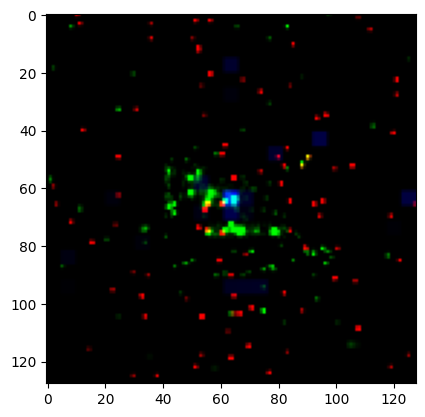

In [153]:
vis_img_plt = plt.imshow(vis_image*255.0)
plt.show()

In [154]:
input_image = preprocess(input_image)
input_image = input_image.to(device)

In [155]:
with torch.no_grad():
    recon_image = model(input_image)
    
recon_vis_image = recon_image.cpu()
recon_vis_image = torch.squeeze(recon_vis_image,dim=0)
recon_vis_image = recon_vis_image.permute(2,1,0)  # recon image visualization ready

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


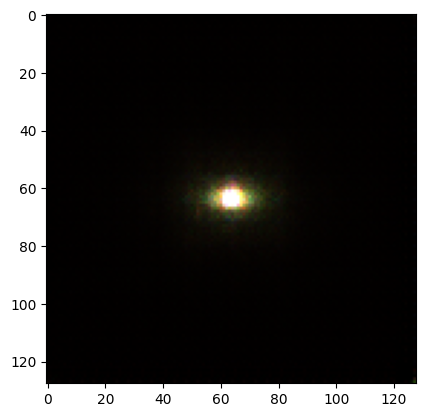

In [159]:
vis_recon_img_plt = plt.imshow(recon_vis_image.numpy()*255.0)
plt.show()